In [ ]:
'''
NATE USE THIS ONE!!!
'''

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from pprint import pprint
from IPython.display import clear_output
from sklearn.metrics import roc_curve

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.optimizers import RMSprop 
from keras.utils import to_categorical


np.random.seed(42)

Mounted at /content/drive/


In [ ]:
num_minerals = 6
ab_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/albite_train_015s_5250.csv'
bt_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/bt_train_015s_5600.csv'
mc_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/mc_train_015s_5600.csv'
fo_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/fo_train_030s_5040.csv'
aug_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/aug_train_030s_5600.csv'
qtz_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/qtz_train_003s_4760.csv'
mineral_paths = np.array([ab_path, bt_path, mc_path, fo_path, aug_path, qtz_path])

X_test_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/Labeled Test/Lraw_granite0dust_test_gbnew_015s_4839.csv' #spectra
y_test_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/Labeled Test/Lraw_granite0dust_test_gbnew_015s_4839.csv' #labels 
label_test = False

min_shift = 101
max_shift = 1100
spectra_len = 4750 #chose min # of spectra from train and test to not mess with different df shapes between data sets during interpolation for now

val_split = 0.15

learning_rate = 0.001
batch_size = 64
epochs = 50

train_accuracy_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/train_accuracy.csv'
val_accuracy_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/val_accuracy.csv'
train_loss_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/train_loss.csv'
val_loss_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/val_loss.csv'
val_cm_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/val_confusion_matrix.csv'
test_cm_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/test_confusion_matrix.csv'
cr_path = '/content/drive/My Drive/ML Spectroscopy/Data/Raw Data/MLP Spectra in CSV Format/classification_report.csv'


In [ ]:
def interpolate_df(df, xnew, spectra_len):
  arr = np.empty((0, spectra_len))
  x = df.values[0]
  for i in range(len(df) - 1):
    y = df.values[i + 1]
    f = interp1d(x, y, bounds_error=False)
    ynew = f(xnew)
    arr = np.append(arr, [ynew], axis = 0)
  return arr

In [ ]:
def load_spectra():
  xnew = np.linspace(min_shift, max_shift, num = spectra_len, endpoint = True)

  X_data = np.empty((0, spectra_len))
  y_data = np.array([])
  for i in range(num_minerals):
    mineral_df = pd.read_csv(mineral_paths[i], header = None)
    mineral_df.drop(mineral_df.columns[[0, 1]], axis = 1, inplace = True)
    mineral_arr = interpolate_df(mineral_df, xnew, spectra_len)
    X_data = np.append(X_data, mineral_arr, axis = 0)
    y_data = np.append(y_data, np.full(len(mineral_arr), i))    
  
  y_data = y_data.astype(int)

  X_test_df = pd.read_csv(X_test_path, header = None)
  X_test_df.drop(X_test_df.columns[[0, -1]], axis = 1, inplace = True)
  X_test = interpolate_df(X_test_df, xnew, spectra_len)

  y_test_df = pd.read_csv(y_test_path, header = None) 
  print(y_test_df.head(3)) #print troubleshoot
  y_test_df = y_test_df.drop(y_test_df.index[0]) #remove first wave row
  print(y_test_df.head(3)) #print troubleshoot
  y_test_df = y_test_df[y_test_df.columns[-1]] #extract only last column
  print(y_test_df.head(3)) #print troubleshoot
  y_test = np.squeeze(y_test_df.to_numpy())
  #print(y_test.head(3)) #print troubleshoot
  
  y_test = y_test.astype(int)

  s = np.arange(X_data.shape[0])
  np.random.shuffle(s)
  X_data = X_data[s]
  y_data = y_data[s]

  X_min = min(np.amin(X_data), np.amin(X_test))
  X_max = max(np.amax(X_data), np.amax(X_test))

  X_data = (X_data - X_min) / (X_max - X_min)
  X_test = (X_test - X_min) / (X_max - X_min)

  data_len = len(X_data)

  X_train = X_data[int(data_len * val_split):]
  y_train = y_data[int(data_len * val_split):]

  X_val = X_data[:int(data_len * val_split)]
  y_val = y_data[:int(data_len * val_split)]

#troubleshooting for X_test y_test shape discrepancy in confmat
  bb=X_test
  cc=y_test.shape 
  ccc=y_test_df.shape
  dd=X_val.shape
  ee=y_val.shape

  print('X_test', bb)
  print('y_test shape', cc)
  print('y_test_df shpae', ccc)
  print(dd)
  print(ee)

  return X_train, y_train, X_val, y_val, X_test, y_test
  

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = load_spectra()

                            0         1         2     ...     2183     2184   2185
0                            NaN   100.473   101.341  ...  1799.59  1800.29  label
1  granite0dust_test_015s_4839-0  1127.220  1136.450  ...  1146.21  1139.40      0
2  granite0dust_test_015s_4839-1  1143.000  1106.990  ...  1120.04  1117.67      0

[3 rows x 2186 columns]
                            0        1        2     ...     2183     2184  2185
1  granite0dust_test_015s_4839-0  1127.22  1136.45  ...  1146.21  1139.40     0
2  granite0dust_test_015s_4839-1  1143.00  1106.99  ...  1120.04  1117.67     0
3  granite0dust_test_015s_4839-2  1115.56  1125.27  ...  1140.97  1140.66     0

[3 rows x 2186 columns]
1    0
2    0
3    0
Name: 2185, dtype: object
(4839, 4750)
(4839,)
(4839,)
(4777, 4750)
(4777,)


In [ ]:
model = Sequential()
model.add(Dense(100, input_shape = (spectra_len,)))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(25))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(num_minerals, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               475100    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                2525      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 156       
Total params: 477,781
Trainable params: 477,781
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer = RMSprop(learning_rate), loss = 'categorical_crossentropy', metrics = ['accuracy'])
training = model.fit(X_train, to_categorical(y_train), batch_size, epochs, validation_data = (X_val, to_categorical(y_val)))

Epoch 1/50
424/424 [==============================] - 4s 8ms/step - loss: 1.1133 - accuracy: 0.5592 - val_loss: 0.5767 - val_accuracy: 0.8993
Epoch 2/50
424/424 [==============================] - 3s 7ms/step - loss: 0.2776 - accuracy: 0.9308 - val_loss: 0.7354 - val_accuracy: 0.6793
Epoch 3/50
424/424 [==============================] - 3s 7ms/step - loss: 0.1195 - accuracy: 0.9674 - val_loss: 0.0327 - val_accuracy: 0.9967
Epoch 4/50
424/424 [==============================] - 3s 7ms/step - loss: 0.0713 - accuracy: 0.9807 - val_loss: 0.0246 - val_accuracy: 0.9975
Epoch 5/50
424/424 [==============================] - 3s 7ms/step - loss: 0.0587 - accuracy: 0.9849 - val_loss: 0.0815 - val_accuracy: 0.9816
Epoch 6/50
424/424 [==============================] - 5s 11ms/step - loss: 0.0680 - accuracy: 0.9810 - val_loss: 0.0211 - val_accuracy: 0.9977
Epoch 7/50
424/424 [==============================] - 3s 8ms/step - loss: 0.0610 - accuracy: 0.9864 - val_loss: 0.0197 - val_accuracy: 0.9983
Epoch

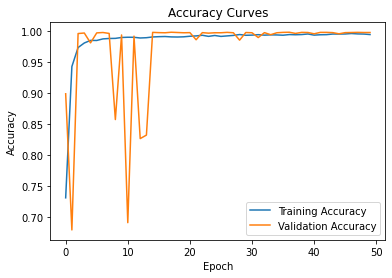

In [ ]:
train_accuracy = training.history['accuracy']
train_accuracy_df = pd.DataFrame(train_accuracy)
#train_accuracy_df.to_csv(train_accuracy_path, index = False, header = False)

val_accuracy = training.history['val_accuracy']
val_accuracy_df = pd.DataFrame(val_accuracy)
#val_accuracy_df.to_csv(val_accuracy_path, index = False, header = False)


plt.plot(train_accuracy, label = 'Training Accuracy')
plt.plot(val_accuracy, label = 'Validation Accuracy')
plt.title('Accuracy Curves')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc = 'best')
plt.show()

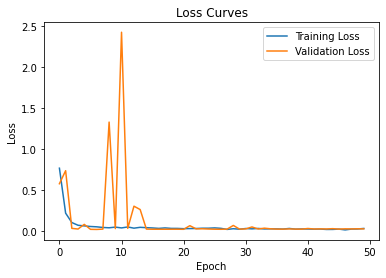

In [ ]:
train_loss = training.history['loss']
train_loss_df = pd.DataFrame(train_loss)
#train_loss_df.to_csv(train_loss_path, index = False, header = False)

val_loss = training.history['val_loss']
val_loss_df = pd.DataFrame(val_loss)
#val_loss_df.to_csv(val_loss_path, index = False, header = False)

plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc = 'best')
plt.show()

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title, path):
  labels = np.arange(num_minerals)
  cm = confusion_matrix(y_true, y_pred, labels)
  cm_df = pd.DataFrame(cm, columns = labels, index = labels)
  #cm_df.to_csv(path, index = True, header = True)
  cm_df.columns.name = 'Predicted'
  cm_df.index.name = 'Actual'
  sn.heatmap(cm_df, annot = True, cmap = 'Blues', fmt = 'd')
  plt.title(title)
  plt.show()

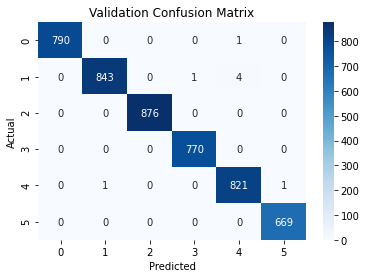

In [ ]:
plot_confusion_matrix(y_val, np.argmax(model.predict(X_val), axis = 1), 'Validation Confusion Matrix', val_cm_path)

Labels: 0 - Albite, 1 - Biotite, 2 - Microcline, 3 - Olivine, 4 - Pyroxene, 5 - Quartz

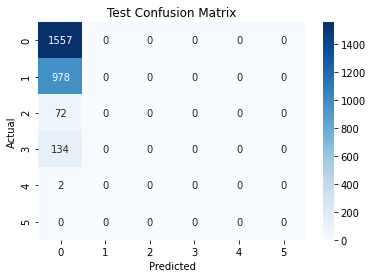

[[nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 ...
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]
 [nan nan nan nan nan nan]]


In [ ]:
plot_confusion_matrix(y_test, np.argmax(model.predict(X_test), axis = 1), 'Test Confusion Matrix', test_cm_path) 
print(model.predict(X_test))

Labels: 0 - Albite, 1 - Biotite, 2 - Microcline, 3 - Olivine, 4 - Pyroxene, 5 - Quartz





In [ ]:
print(classification_report(y_test, np.argmax(model.predict(X_test), axis = -1)))

cr = classification_report(y_test, np.argmax(model.predict(X_test), axis = -1), output_dict = True)
cr_df = pd.DataFrame(cr).transpose()
#cr_df.to_csv(cr_path, index = True, header = True)

              precision    recall  f1-score   support

           0       0.32      1.00      0.49      1557
           1       0.00      0.00      0.00       978
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00       134
           4       0.00      0.00      0.00         2
           9       0.00      0.00      0.00      2096

    accuracy                           0.32      4839
   macro avg       0.05      0.17      0.08      4839
weighted avg       0.10      0.32      0.16      4839

